In [7]:
import pandas as pd
from datasets import load_dataset
from transformers import AutoTokenizer, AutoConfig
import json
import matplotlib.pyplot as plt
from pathlib import Path

In [8]:
custom_dataset = load_dataset("csv", data_files=['../datasets/train.csv'], split='train')

Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 2129.09it/s]
Generating train split: 0 examples [00:00, ? examples/s]/home/themeinerlp/miniconda3/envs/FaweCommandGeneration2/lib/python3.11/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
                                                        

Dataset csv downloaded and prepared to /home/themeinerlp/.cache/huggingface/datasets/csv/default-2d1e09a968455525/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


In [9]:
from dataclasses import dataclass, field
from pathlib import Path
from typing import Optional

from transformers import AutoConfig, AutoTokenizer, AutoModelForSeq2SeqLM
from transformers.trainer_utils import get_last_checkpoint


@dataclass
class ModelArguments:
    """
    Arguments pertaining to which model/config/tokenizer we are going to fine-tune from.
    """

    model_name_or_path: str = field(
        metadata={
            "help": "Path to pretrained model or model identifier from huggingface.co/models"
        }
    )
    config_name: Optional[str] = field(
        default=None,
        metadata={
            "help": "Pretrained config name or path if not the same as model_name"
        },
    )
    tokenizer_name: Optional[str] = field(
        default=None,
        metadata={
            "help": "Pretrained tokenizer name or path if not the same as model_name"
        },
    )
    cache_dir: Optional[str] = field(
        default=None,
        metadata={
            "help": "Where to store the pretrained models downloaded from huggingface.co"
        },
    )
    use_fast_tokenizer: bool = field(
        default=True,
        metadata={
            "help": "Whether to use one of the fast tokenizer (backed by the tokenizers library) or not."
        },
    )
    model_revision: str = field(
        default="main",
        metadata={
            "help": "The specific model version to use (can be a branch name, tag name or commit id)."
        },
    )
    use_auth_token: bool = field(
        default=False,
        metadata={
            "help": "Will use the token generated when running `transformers-cli login` (necessary to use this script "
                    "with private models)."
        },
    )


@dataclass
class DataTrainingArguments:
    """
    Arguments pertaining to what data we are going to input our model for training and eval.
    """

    source_lang: str = field(
        default=None, metadata={"help": "Source language id for translation."}
    )
    target_lang: str = field(
        default=None, metadata={"help": "Target language id for translation."}
    )

    dataset_name: Optional[str] = field(
        default=None,
        metadata={"help": "The name of the dataset to use (via the datasets library)."},
    )
    input_column_name: Optional[str] = field(
        default=None,
        metadata={"help": "The column name of the input in the dataset."},
    )
    target_column_name: Optional[str] = field(
        default=None,
        metadata={"help": "The column name of the target in the dataset."},
    )
    e2e: Optional[bool] = (
        field(default=False, metadata={"help": "Prepare data for e2e"}),
    )
    dataset_config_name: Optional[str] = field(
        default=None,
        metadata={
            "help": "The configuration name of the dataset to use (via the datasets library)."
        },
    )
    dataset_field_name: Optional[str] = field(
        default=None,
        metadata={"help": "The field name, useful when the data is stored as json."},
    )
    train_file: Optional[str] = field(
        default=None, metadata={"help": "The input training data file (a jsonlines)."}
    )
    validation_file: Optional[str] = field(
        default=None,
        metadata={
            "help": "An optional input evaluation data file to evaluate the metrics (sacreblue) on "
                    "a jsonlines file."
        },
    )
    test_file: Optional[str] = field(
        default=None,
        metadata={
            "help": "An optional input test data file to evaluate the metrics (sacreblue) on "
                    "a jsonlines file."
        },
    )
    overwrite_cache: bool = field(
        default=False,
        metadata={"help": "Overwrite the cached training and evaluation sets"},
    )
    preprocessing_num_workers: Optional[int] = field(
        default=None,
        metadata={"help": "The number of processes to use for the preprocessing."},
    )
    max_source_length: Optional[int] = field(
        default=1024,
        metadata={
            "help": "The maximum total input sequence length after tokenization. Sequences longer "
                    "than this will be truncated, sequences shorter will be padded."
        },
    )
    max_target_length: Optional[int] = field(
        default=128,
        metadata={
            "help": "The maximum total sequence length for target text after tokenization. Sequences longer "
                    "than this will be truncated, sequences shorter will be padded."
        },
    )
    val_max_target_length: Optional[int] = field(
        default=None,
        metadata={
            "help": "The maximum total sequence length for validation target text after tokenization. Sequences longer "
                    "than this will be truncated, sequences shorter will be padded. Will default to `max_target_length`."
                    "This argument is also used to override the ``max_length`` param of ``model.generate``, which is used "
                    "during ``evaluate`` and ``predict``."
        },
    )
    pad_to_max_length: bool = field(
        default=False,
        metadata={
            "help": "Whether to pad all samples to model maximum sentence length. "
                    "If False, will pad the samples dynamically when batching to the maximum length in the batch. More "
                    "efficient on GPU but very bad for TPU."
        },
    )
    max_train_samples: Optional[int] = field(
        default=None,
        metadata={
            "help": "For debugging purposes or quicker training, truncate the number of training examples to this "
                    "value if set."
        },
    )
    max_eval_samples: Optional[int] = field(
        default=None,
        metadata={
            "help": "For debugging purposes or quicker training, truncate the number of evaluation examples to this "
                    "value if set."
        },
    )
    max_predict_samples: Optional[int] = field(
        default=None,
        metadata={
            "help": "For debugging purposes or quicker training, truncate the number of prediction examples to this "
                    "value if set."
        },
    )
    num_beams: Optional[int] = field(
        default=None,
        metadata={
            "help": "Number of beams to use for evaluation. This argument will be passed to ``model.generate``, "
                    "which is used during ``evaluate`` and ``predict``."
        },
    )
    repetition_penalty: float = field(
        default=1.0,
        metadata={
            "help": "The parameter for repetition penalty. 1.0 means no penalty. See "
                    "https://arxiv.org/abs/1909.05858 for more details."
        },
    )
    length_penalty: float = field(
        default=1.0,
        metadata={
            "help": "Exponential penalty to the length that is used with beam-based generation. "
                    "It is applied as an exponent to the sequence length, "
                    "which in turn is used to divide the score of the sequence. "
                    "Since the score is the log likelihood of the sequence (i.e. negative), length_penalty > 0.0 "
                    "promotes longer sequences, while length_penalty < 0.0 encourages shorter sequences."
        },
    )
    ignore_pad_token_for_loss: bool = field(
        default=True,
        metadata={
            "help": "Whether to ignore the tokens corresponding to padded labels in the loss computation or not."
        },
    )
    source_prefix: Optional[str] = field(
        default=None,
        metadata={
            "help": "A prefix to add before every source text (useful for T5 models)."
        },
    )
    forced_bos_token: Optional[str] = field(
        default=None,
        metadata={
            "help": "The token to force as the first generated token after the :obj:`decoder_start_token_id`."
                    "Useful for multilingual models like :doc:`mBART <../model_doc/mbart>` where the first generated token "
                    "needs to be the target language token.(Usually it is the target language token)"
        },
    )

    def __post_init__(self):

        if self.train_file is not None:
            extension = self.train_file.split(".")[-1]
            assert extension == "json", "`train_file` should be a json file."
        if self.validation_file is not None:
            extension = self.validation_file.split(".")[-1]
            assert extension == "json", "`validation_file` should be a json file."
        if self.val_max_target_length is None:
            self.val_max_target_length = self.max_target_length


def load_model(model_path: str) -> tuple[AutoConfig, AutoTokenizer, AutoModelForSeq2SeqLM]:
    if Path(model_path).exists():
        last_checkpoint = get_last_checkpoint(model_path)
        if last_checkpoint is not None:
            model_path = last_checkpoint

    config = AutoConfig.from_pretrained(model_path)
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_path, config=config)
    print("Loaded model from", model_path)
    return config, tokenizer, model

In [10]:
script_config = json.loads(Path("../script_config.json").read_text("utf-8"))
config, tokenizer, model = load_model(Path("..") / Path(script_config["output_dir"]))

Loaded model from ../output/models/english-fawecommandgerneration-mt5-small-512


In [11]:
df = pd.DataFrame(custom_dataset)

In [12]:

df["paragraph_answer_tokens"] = df["command"].map(lambda p: tokenizer.tokenize(p, truncation=True))
df["paragraph_answer_tokens_len"] = df["paragraph_answer_tokens"].map(len)
df[["command", "question", "paragraph_answer_tokens", "paragraph_answer_tokens_len"]].head(16)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


,command,description,paragraph_answer_tokens,paragraph_answer_tokens_len
0,//gmask air,create a global air mask,"[▁//, g, mask, ▁air]",4
1,//gmask,disable global mask,"[▁//, g, mask]",3
2,//set stone,set stone,"[▁//, set, ▁stone]",3
3,//undo,undo my last operation,"[▁//, undo]",2
4,//replace stone air,replace stone to air,"[▁//, replace, ▁stone, ▁air]",4
5,//br sphere stone 5,bind me a brush sphere with a size of 5 and th...,"[▁//, br, ▁, sphere, ▁stone, ▁5]",6
6,//wand,give me a wand,"[▁//, wand]",2
7,//gmask y>15,create a mask that allows on a mask above 15 i...,"[▁//, g, mask, ▁, y, >, 15, ▁]",8
8,//deform z+=0.314*sin(y^2+x^2),make a curve deformation with a intensity of 0...,"[▁//, de, form, ▁z, +=, 0.31, 4*, sin, (, y, ^...",15
9,//deform z+=0.5*sin(y^2+x^2),How make i a curve deformation with a intensit...,"[▁//, de, form, ▁z, +=, 0.5, *, sin, (, y, ^2,...",15


In [13]:
df = pd.DataFrame(custom_dataset)
df["q_len"] = df["question"].map(tokenizer.encode).map(len)
df["label_len"] = df["command"].map(tokenizer.encode).map(len)
df.sort_values(by=["q_len"], ascending=False, inplace=True)
print(df.head())


                                               command  \
192  //br blob #simplex[21][lime_terracotta,gray_te...   
182  //br blob #simplex[10][green_wool,yellow_wool]...   
186  //br blob #simplex[6][cyan_wool,light_gray_woo...   
190  //br blob #simplex[13][purple_terracotta,pink_...   
185  //br blob #simplex[20][lime_wool,gray_wool] 20...   

                                           description  q_len  label_len  
192  Create a blob using a simplex noise pattern wi...     74         29  
182  Create a blob using a simplex noise pattern wi...     73         24  
186  Create a blob using a simplex noise pattern wi...     73         25  
190  Create a blob using a simplex noise pattern wi...     73         28  
185  Create a blob using a simplex noise pattern wi...     73         25  


In [14]:
df.sort_values(by=["label_len"], ascending=False, inplace=True)
print(df.head())

                                               command  \
222  //generate light_blue_wool N=18; a=atan2(x,z);...   
223  //generate light_gray_wool N=20; a=atan2(x,z);...   
221  //generate gray_wool N=17; a=atan2(x,z); r=(co...   
213  //generate purple_wool N=9; a=atan2(x,z); r=(c...   
211  //generate green_wool N=7; a=atan2(x,z); r=(co...   

                                           description  q_len  label_len  
222  Create a cool 18-sided shape on the ground usi...     38         65  
223  Create a cool 20-sided shape on the ground usi...     39         65  
221  Create a cool 17-sided shape on the ground usi...     38         64  
213  Create a cool 9-sided shape on the ground usin...     38         64  
211  Create a cool 7-sided shape on the ground usin...     37         63  


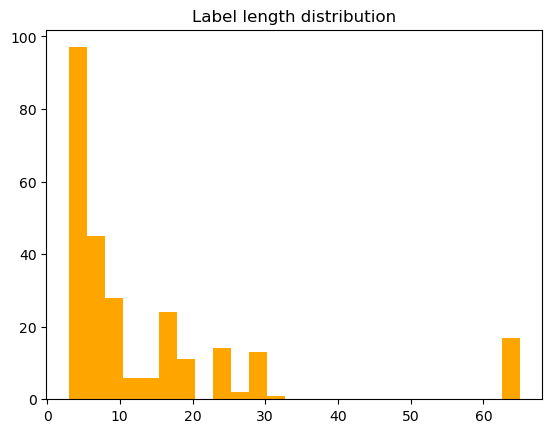

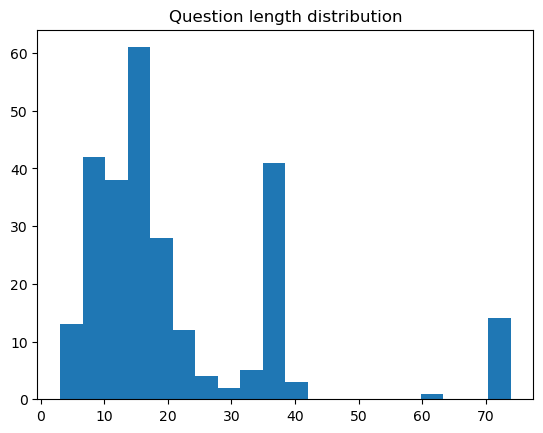

In [15]:
plt.hist(df["label_len"], bins=25, color="orange")
plt.title("Label length distribution")
plt.show()
plt.hist(df["q_len"], bins=20)
plt.title("Question length distribution")
plt.show()

In [8]:
text = """"""

len(tokenizer.tokenize(text))


1162